# <center> Delitos en CDMX</center>
## <center> EDA y Baseline: SARIMA</center>

## Librerias importantes

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import AgglomerativeClustering as AC
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## Cargamos nuestros datos

Definimos como variables de tipo `fecha` a $\texttt{fecha_hechos}$ y $\texttt{fecha_inicio}$ y eliminamos dos columnas ($\texttt{ao_inicio}$ y $\texttt{mes_inicio}$) de la base de datos original, ya que sería utilizar información repetida.

In [2]:
FGJ_carpetas = pd.read_csv("../Data/FGJ_carpetas.csv", parse_dates=["fecha_hechos", "fecha_inicio"])
FGJ_carpetas.drop(columns=["ao_inicio", "mes_inicio"], inplace=True)
print(FGJ_carpetas.info())
#print(FGJ_carpetas.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390698 entries, 0 to 1390697
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Unnamed: 0            1390698 non-null  int64         
 1   ao_hechos             1390698 non-null  int64         
 2   mes_hechos            1390698 non-null  object        
 3   fecha_hechos          1390698 non-null  datetime64[ns]
 4   fecha_inicio          1390698 non-null  datetime64[ns]
 5   delito                1390698 non-null  object        
 6   fiscalia              1390698 non-null  object        
 7   agencia               1390698 non-null  object        
 8   unidad_investigacion  1390698 non-null  object        
 9   categoria_delito      1390698 non-null  object        
 10  colonia_hechos        1390698 non-null  object        
 11  alcaldia_hechos       1390698 non-null  object        
 12  longitud              1390698 non-null  fl

Definimos como indicies las fechas cuando ocurrieron los hechos delictivos, es decir, con la variable $\texttt{fecha_hechos}$

In [3]:
FGJ_carpetas.index = pd.DatetimeIndex(FGJ_carpetas.fecha_hechos)

Mostramos los primeros 3 registros, solo para comprobar como fueron cargados nuestros datos

In [3]:
FGJ_carpetas.head(3)

,Unnamed: 0,ao_hechos,mes_hechos,fecha_hechos,fecha_inicio,delito,fiscalia,agencia,unidad_investigacion,categoria_delito,colonia_hechos,alcaldia_hechos,longitud,latitud
0,1,2016,Enero,2016-01-31 22:16:00,2016-02-01 00:25:44,DAÑO EN PROPIEDAD AJENA INTENCIONAL,INVESTIGACIÓN EN BENITO JUÁREZ,BJ-2,UI-3CD,DELITO DE BAJO IMPACTO,AMÉRICAS UNIDAS,BENITO JUAREZ,-99.140215,19.380315
1,2,2016,Enero,2016-01-31 20:50:00,2016-02-01 00:52:37,ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...,INVESTIGACIÓN PARA LA ATENCIÓN DEL DELITO DE R...,ORIENTEII,UI-3CD,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,LOS CIPRESES,IZTAPALAPA,-99.108403,19.352859
2,3,2016,Febrero,2016-02-01 00:30:00,2016-02-01 01:33:26,NARCOMENUDEO POSESION SIMPLE,"INVESTIGACIÓN PARA LA ATENCIÓN DE NIÑOS, NIÑAS...",57,UI-3CD,DELITO DE BAJO IMPACTO,UNIDAD VICENTE GUERRERO,IZTAPALAPA,-99.061321,19.356451


## EDA
Vemos cuantos registros tenemos por tipo de delito. Algo *interesante* a remarcar son los feminicidios, ya que solo se ve 1 registrado y si prestamos atención en las noticias del día a día, podemos pensar que debería haber más registros.

In [5]:
FGJ_carpetas["categoria_delito"].value_counts()

DELITO DE BAJO IMPACTO                                     1110775
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA         80354
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                         69732
HECHO NO DELICTIVO                                           49673
ROBO A NEGOCIO CON VIOLENCIA                                 22717
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                        14116
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA        11981
HOMICIDIO DOLOSO                                              6872
VIOLACIÓN                                                     6696
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO                 4765
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA       4738
ROBO A CASA HABITACIÓN CON VIOLENCIA                          3480
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA       2550
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA                 1414
ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA                      

Graficamos la información anterior

<AxesSubplot:title={'center':'Tasa de delitos cometidos entre 2016-2022'}>

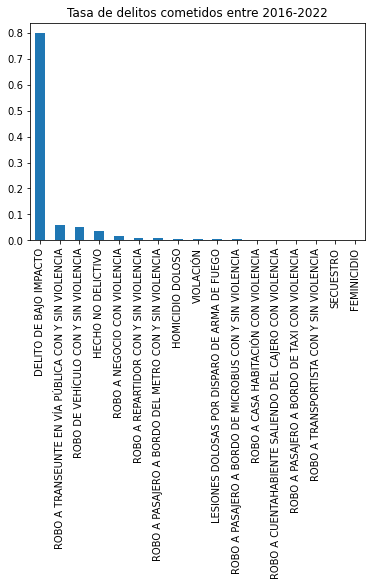

In [6]:
FGJ_carpetas["categoria_delito"].value_counts(normalize=True).plot(kind = "bar", 
                                                                   title = "Tasa de delitos cometidos entre 2016-2022")

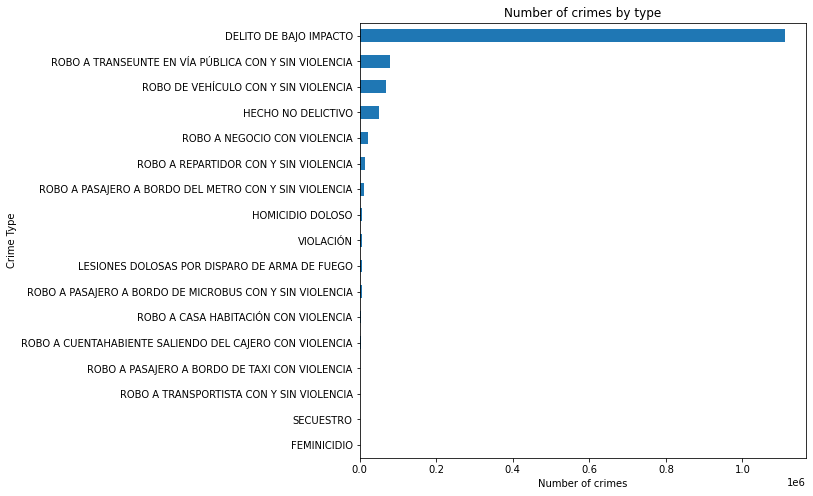

In [8]:
plt.figure(figsize=(8,8))
FGJ_carpetas.groupby([FGJ_carpetas['categoria_delito']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

Nos llama la atención la categoria de **Delitos de bajo impacto**. Mostramos las primeras clases de delitos más frecuentes que son considerados de bajo impacto. 

Algo alarmante de ver aquí es que el **abuso sexual** se considera dentro de esta categoria, siendo incluso más frecuente que el sexto delito más frecuento de los que no son considerados como de bajo impacto.

In [7]:
FGJ_carpetas[FGJ_carpetas["categoria_delito"] == "DELITO DE BAJO IMPACTO"]["delito"].value_counts()[:20]

VIOLENCIA FAMILIAR                                                      159645
FRAUDE                                                                   86405
ROBO DE OBJETOS                                                          84110
AMENAZAS                                                                 83310
ROBO A NEGOCIO SIN VIOLENCIA                                             69059
ROBO DE ACCESORIOS DE AUTO                                               47406
ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO                              40210
ROBO A CASA HABITACION SIN VIOLENCIA                                     32645
DESPOJO                                                                  23875
ABUSO DE CONFIANZA                                                       23453
NARCOMENUDEO POSESION SIMPLE                                             21899
DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO VEHICULAR A AUTOMOVIL       21866
USURPACIÓN DE IDENTIDAD                             

Vemos la cantidad de registros de delitos cometidos por año.

In [9]:
FGJ_carpetas["ao_hechos"].value_counts().sort_index()

2016    187319
2017    218043
2018    244732
2019    235368
2020    195039
2021    211468
2022     98729
Name: ao_hechos, dtype: int64

Podemos ver que para el año 2022 hay pocos delitos, lo que no es de sorprenderse ya que el año aun esta en curso. 

Algo que si hay que notar, es que a partir del 2019 se nota una disminución en la cantidad de delitos, sobre todo para el año 2020. Podemos decir que el efecto COVID está presente. Quizás haya que considerar este efecto para futuros análisis.

<AxesSubplot:>

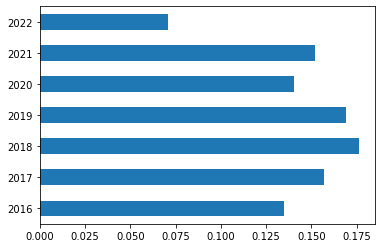

In [10]:
FGJ_carpetas["ao_hechos"].value_counts(normalize=True).sort_index().plot(kind = "barh")

Cantidad de delitos por mes.

In [11]:
FGJ_carpetas["mes_hechos"].value_counts().sort_index()

Abril         118921
Agosto        110892
Diciembre     102998
Enero         121395
Febrero       121297
Julio         106360
Junio         119038
Marzo         131641
Mayo          126749
Noviembre     108552
Octubre       115089
Septiembre    107766
Name: mes_hechos, dtype: int64

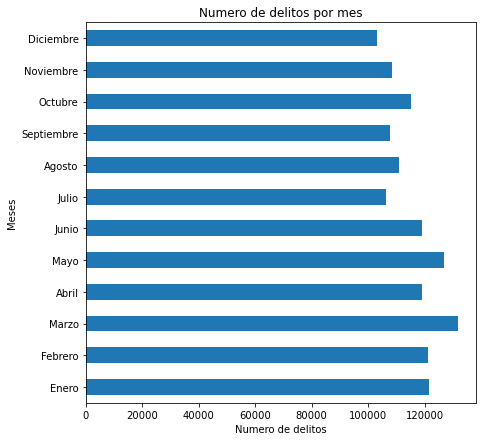

In [12]:
mes = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre",
      "Noviembre", "Diciembre"]
plt.figure(figsize=(7,7))
FGJ_carpetas.groupby([FGJ_carpetas.index.month]).size().plot(kind='barh', title = "Numero de delitos por mes")
plt.xlabel("Numero de delitos")
plt.ylabel("Meses")
plt.yticks(np.arange(12),mes)
plt.show()

Cantidad de delitos por día.

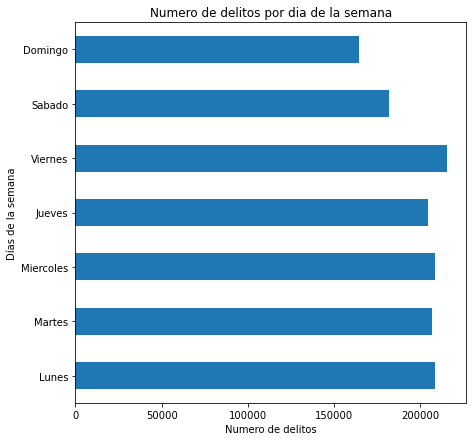

In [47]:
dias = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]
plt.figure(figsize=(7,7))
FGJ_carpetas.groupby([FGJ_carpetas.index.dayofweek]).size().plot(kind='barh', title = "Numero de delitos por dia de la semana")
plt.xlabel("Numero de delitos")
plt.ylabel("Días de la semana")
plt.yticks(np.arange(7),dias)
plt.show()

Cantidad de delitos por delegación. Podemos ver como Iztapalapa y Cuahtemoc son más *peligrosos*, por decirlo de alguna manera.

<AxesSubplot:>

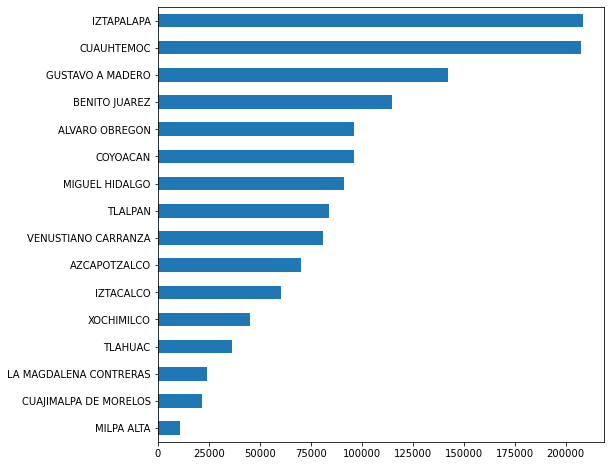

In [14]:
plt.figure(figsize=(8,8))
FGJ_carpetas["alcaldia_hechos"].value_counts().sort_values(ascending=True).plot(kind = "barh")

Vemos las zonas donde mayor se concentran los delitos.

(19.08, 19.6)

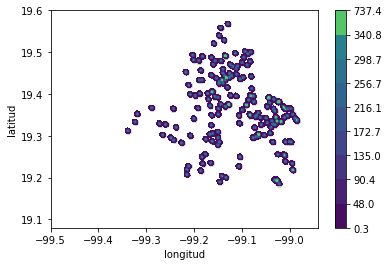

In [29]:
crimes_new = FGJ_carpetas[FGJ_carpetas['categoria_delito'] == 'SECUESTRO']
sns.regplot(x='longitud', y='latitud', data= crimes_new[['longitud','latitud']], fit_reg=False, scatter_kws={"color":"grey","alpha":0.3})
sns.kdeplot(data = crimes_new[['latitud','longitud']], x = "longitud", y="latitud",
                 cmap="viridis", 
                 bw_method=.02,
                 #n_levels=10,
                 cbar=True, 
                 shade=True, 
                 thresh=0.0005, warn_singular=False)
plt.xlim(-99.5,-98.94)
plt.ylim(19.08,19.6)


Ahora lo hacemos por tipo de delito. Algo a mejorar en esta parte es graficar estos puntos sobre el mapa de CDMX para saber en que delegaciones son estas manchas.

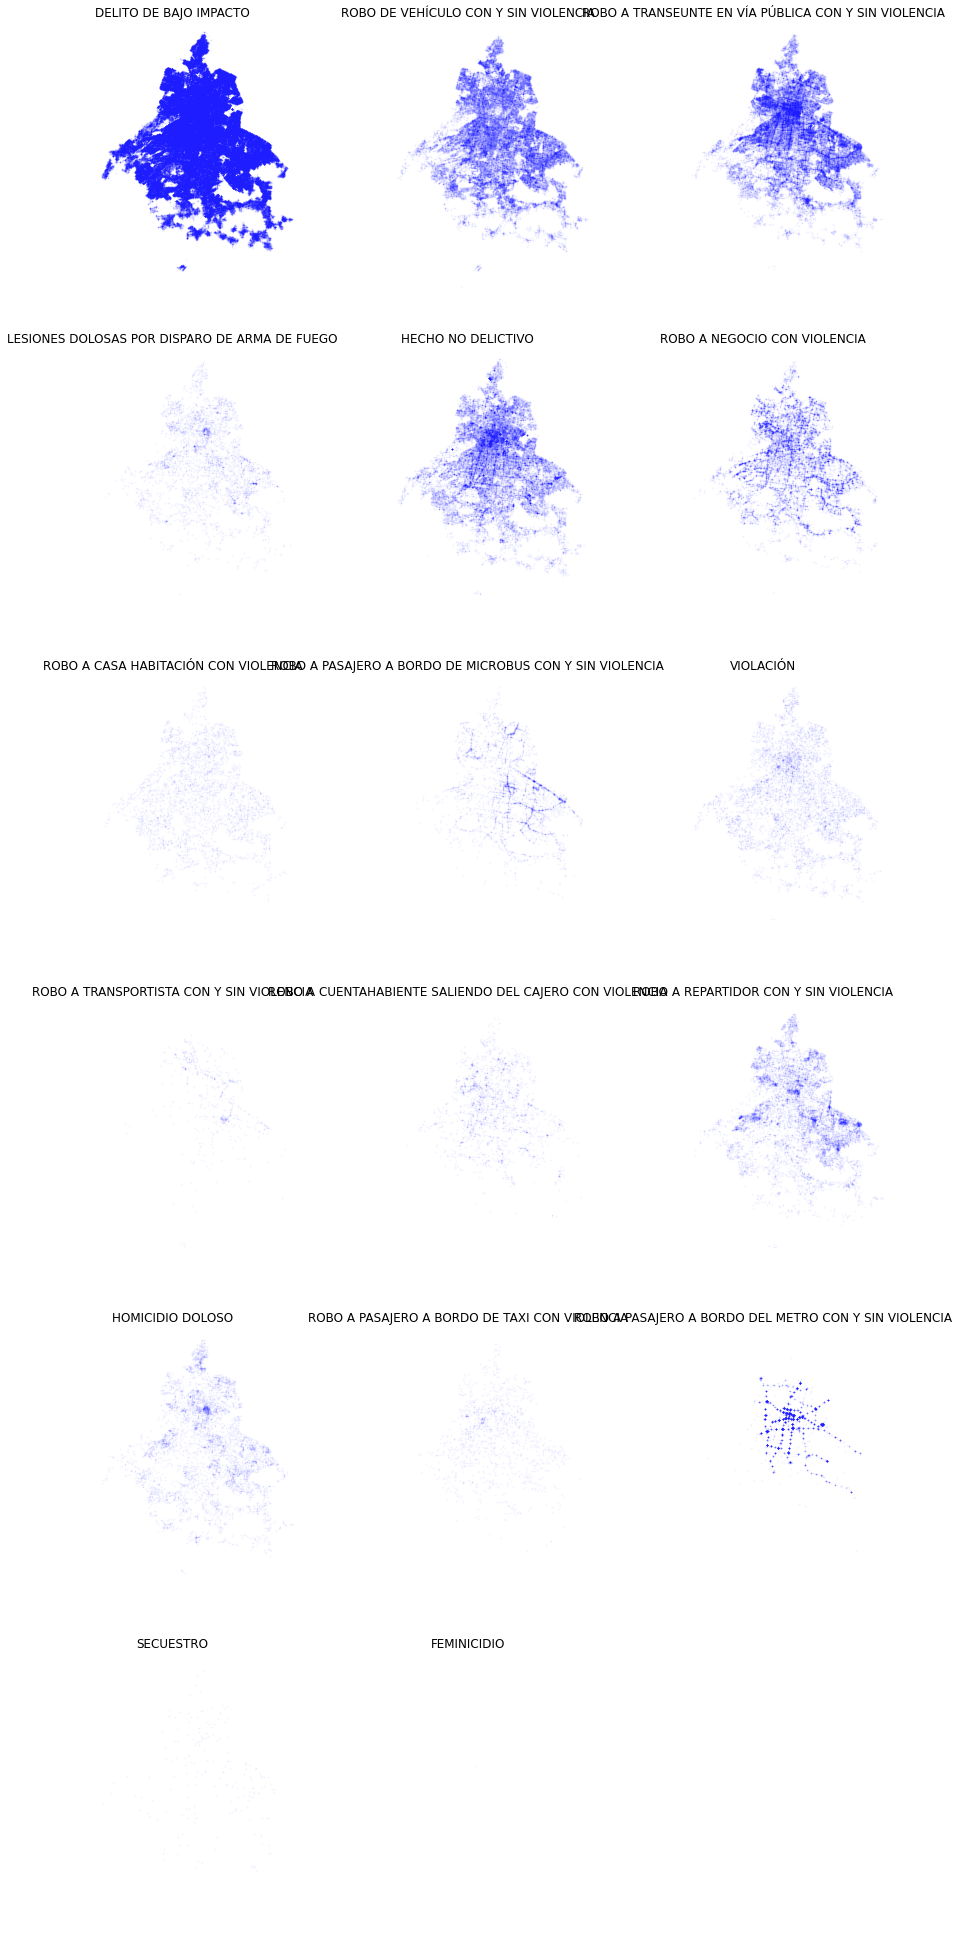

In [30]:
delitos = ['DELITO DE BAJO IMPACTO', 'ROBO DE VEHÍCULO CON Y SIN VIOLENCIA',
       'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA',
       'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
       'HECHO NO DELICTIVO', 'ROBO A NEGOCIO CON VIOLENCIA',
       'ROBO A CASA HABITACIÓN CON VIOLENCIA',
       'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
       'VIOLACIÓN', 'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA',
       'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
       'ROBO A REPARTIDOR CON Y SIN VIOLENCIA', 'HOMICIDIO DOLOSO',
       'ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA',
       'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
       'SECUESTRO', 'FEMINICIDIO']

fig = plt.figure(figsize=(15,35))
for i, cat_deli in enumerate(delitos):
    ax = fig.add_subplot(int(np.ceil(float(len(delitos)) / 3)), 3, i+1)
    delitos_cat = FGJ_carpetas[FGJ_carpetas['categoria_delito']==cat_deli]
    sns.regplot(x='longitud', y='latitud', data= delitos_cat[['longitud','latitud']], fit_reg=False, 
                scatter_kws={'alpha':.03, 'color':'blue', "s":1}, ax=ax)
    ax.set_title(cat_deli)
    ax.set_xlim(-99.45,-98.94)
    ax.set_ylim(19.08,19.6)
    ax.set_axis_off()
        
plt.show()

## Series de tiempo

Serie de tiempo por día. Podemos ver que es muy ruidosa.

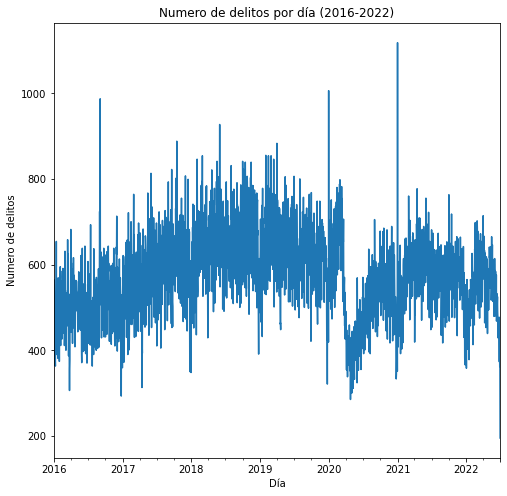

In [19]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("D", on = "fecha_hechos").size().plot(legend = False, title = "Numero de delitos por día (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Día")
plt.show()

Serie por semana.

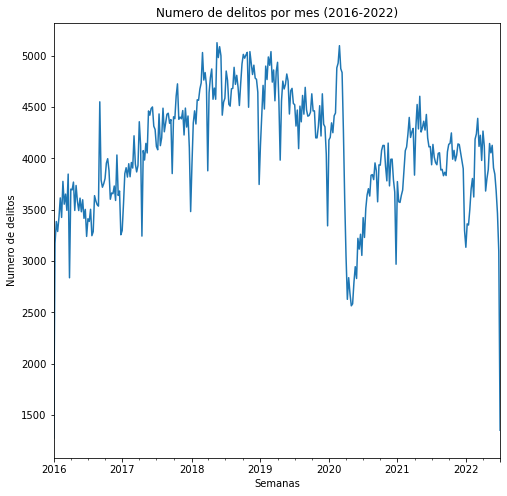

In [36]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("W", on = "fecha_hechos").size().plot(legend = False, 
                                                                               title = "Numero de delitos por mes (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Semanas")
plt.show()

Serie mensual.

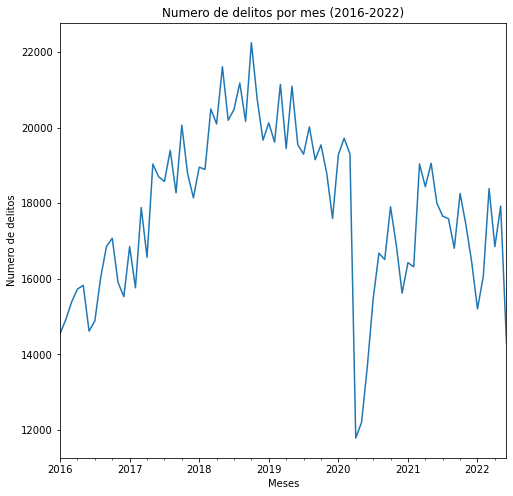

In [21]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("M", on = "fecha_hechos").size().plot(legend = False, title = "Numero de delitos por mes (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Meses")
plt.show()

Serie anual.

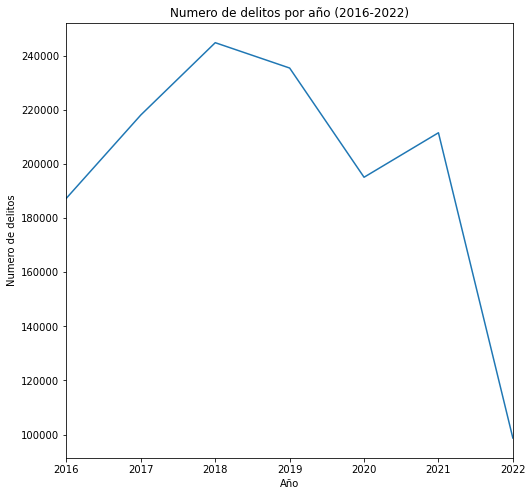

In [22]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("Y", on = "fecha_hechos").size().plot(legend = False, title = "Numero de delitos por año (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Año")
plt.show()

### Sumas móviles

Suma mavil para datos semanales.

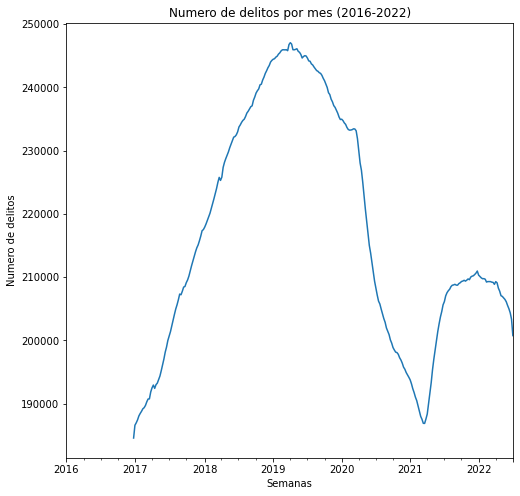

In [40]:
#prueba
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("W", on = "fecha_hechos").size().rolling(52).sum().plot(legend = False, 
                                                                               title = "Numero de delitos por mes (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Semanas")
plt.show()

Suma movil para datos diarios.

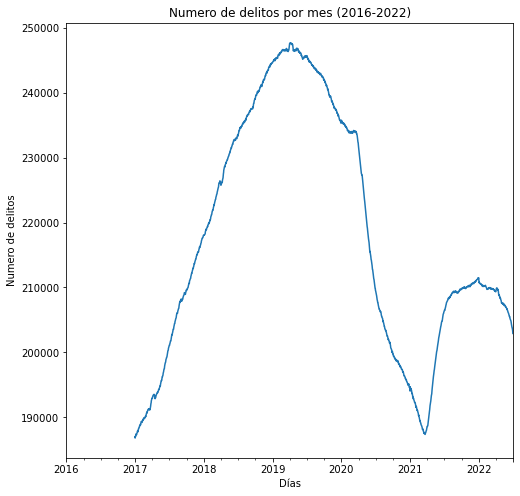

In [20]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("D", on = "fecha_hechos").size().rolling(365).sum().plot(legend = False, 
                                                                               title = "Numero de delitos por mes (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Días")
plt.show()

Suma movil diaria por categoria de delito.

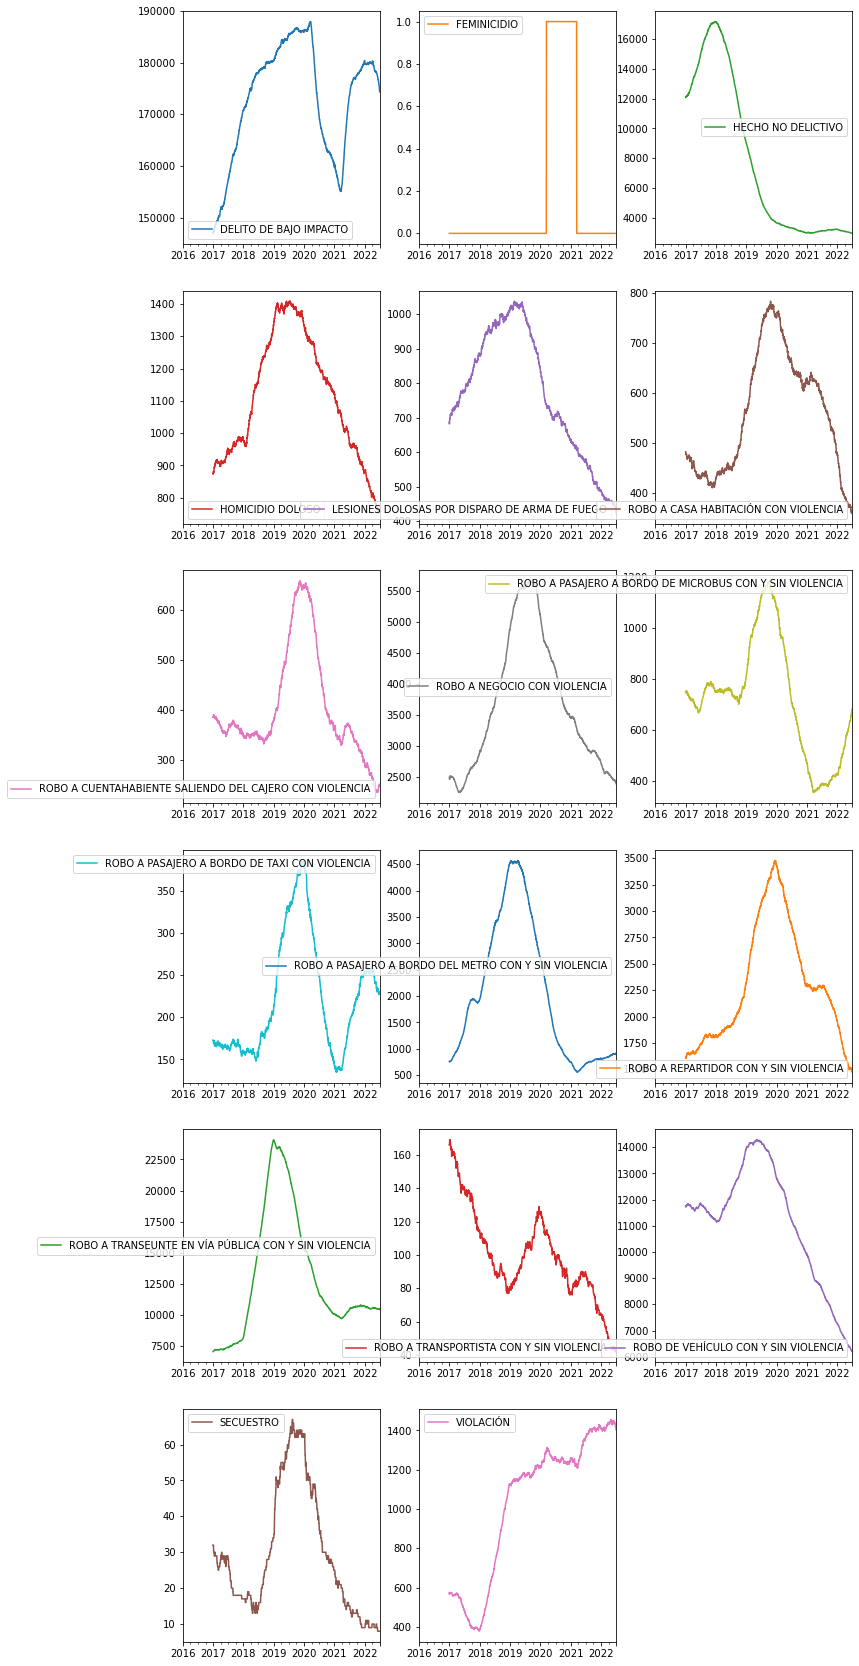

In [14]:
cat_x_dia = FGJ_carpetas.pivot_table("Unnamed: 0",columns="categoria_delito", index = FGJ_carpetas.index.date, 
                        aggfunc=np.size, fill_value=0)
cat_x_dia.index = pd.DatetimeIndex(cat_x_dia.index)
grafico_x_cat = cat_x_dia.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

Suma movil semanal por categoria de delito.

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

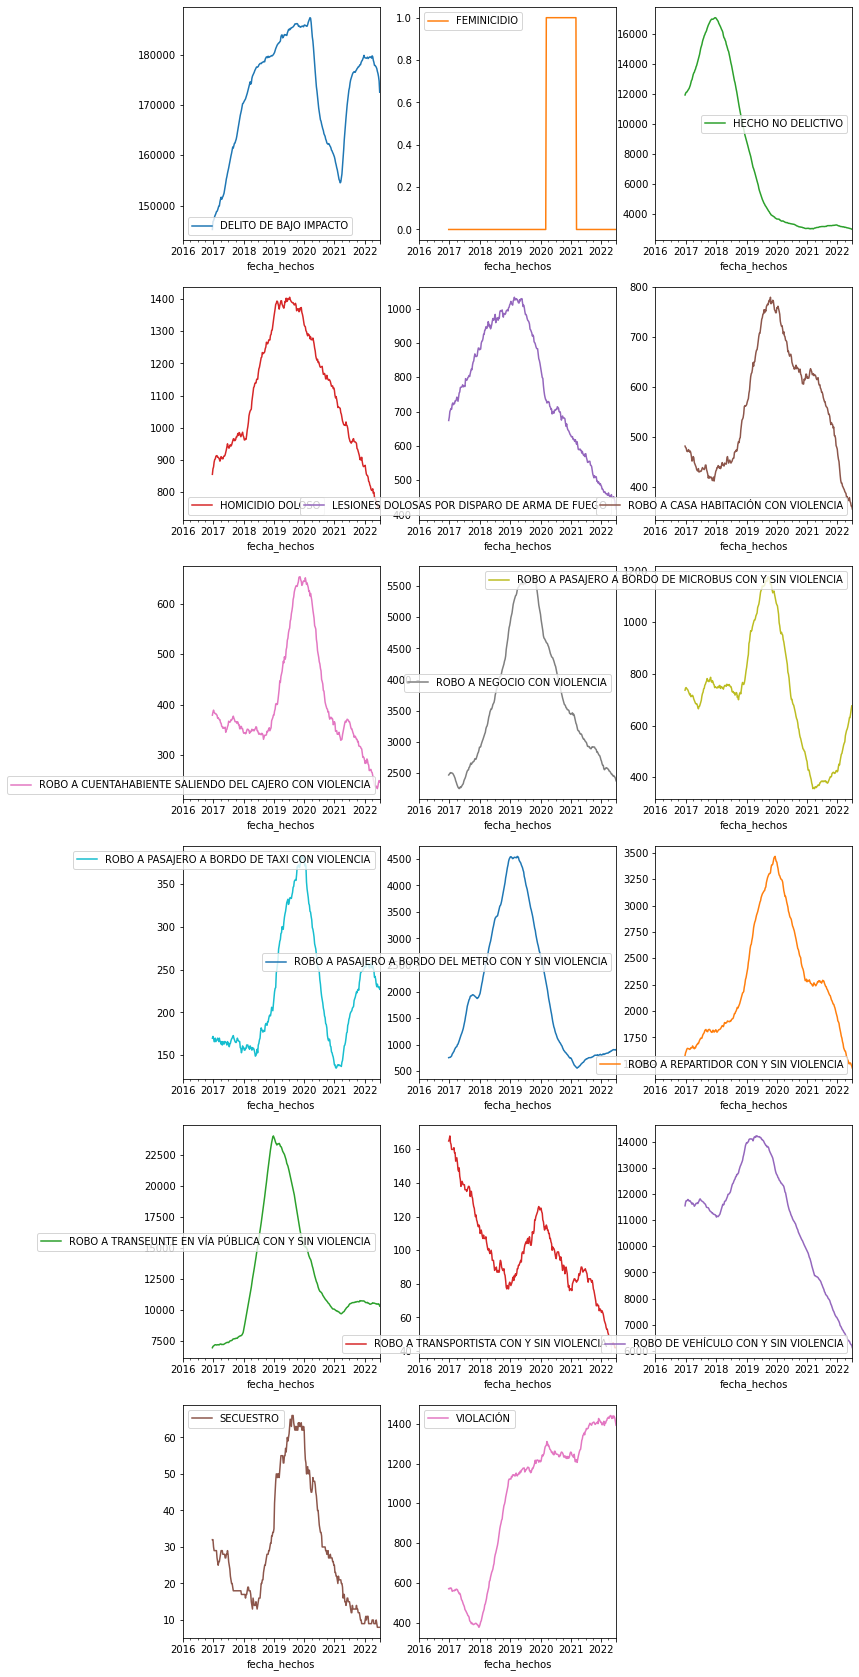

In [59]:
cat_x_semana = FGJ_carpetas.pivot_table("Unnamed: 0",columns="categoria_delito", aggfunc=np.size, fill_value=0, 
                                        index=FGJ_carpetas['fecha_hechos'].dt.to_period('W'))
cat_x_semana.rolling(52).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

## Cluster Aglomerativo

Extraido de:

In [19]:
scaler = StandardScaler(with_mean=True, with_std=True) # z-scale
X_std = scaler.fit_transform(cat_x_hora)

In [4]:
def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled), np.abs(np.min(df_marginal_scaled))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)

Relación entre tipo de delito y hora del día.

In [9]:
cat_x_hora = FGJ_carpetas.pivot_table(values = "Unnamed: 0", index = "categoria_delito", 
                         columns=FGJ_carpetas.index.hour, aggfunc=np.size).fillna(0)

C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


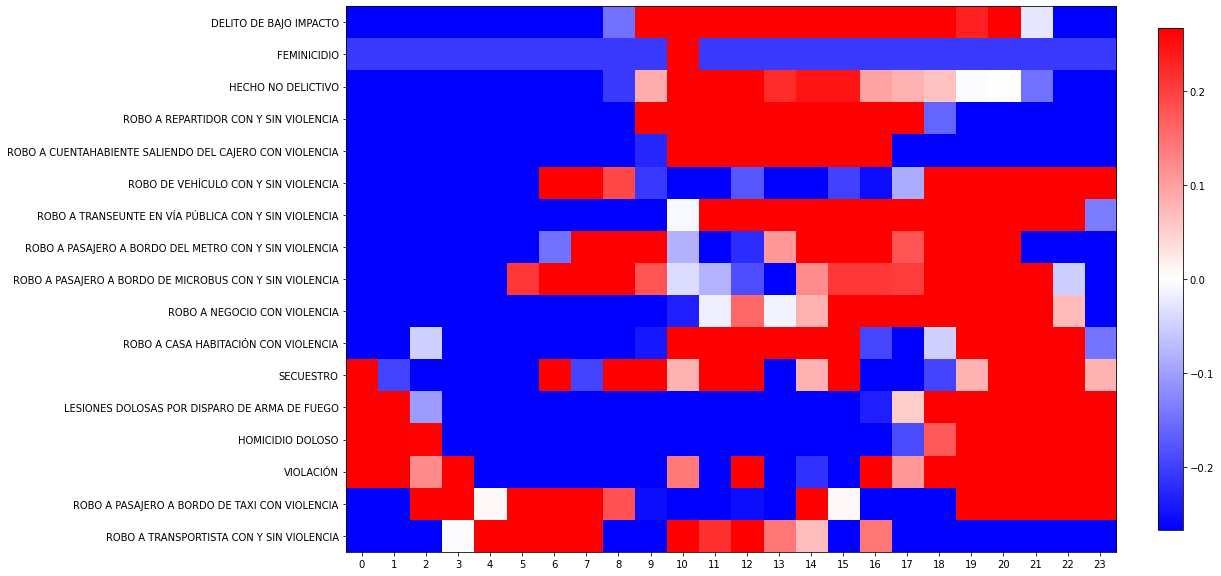

In [10]:
plt.figure(figsize=(15,12))
scale_and_plot(cat_x_hora)

Relación entre la Delegación y hora del día.

In [25]:
hora_x_del = FGJ_carpetas.pivot_table(values = "Unnamed: 0", index='alcaldia_hechos', 
                                      columns=FGJ_carpetas.index.hour, aggfunc=np.size).fillna(0)

C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


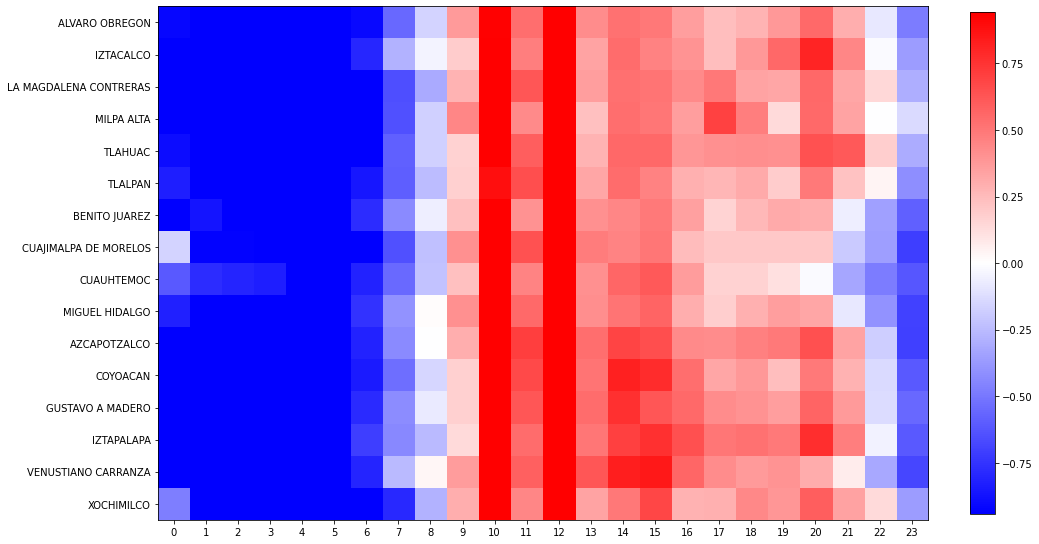

In [26]:
plt.figure(figsize=(15,12))
scale_and_plot(hora_x_del)

Relación entre la cantidad de delitos cometidos al día en cada hora.

In [13]:
hora_x_dia = FGJ_carpetas.pivot_table(values="Unnamed: 0", index=FGJ_carpetas.index.hour, 
                                      columns=FGJ_carpetas.index.weekday, aggfunc=np.size).fillna(0)
hora_x_dia     = hora_x_dia.T

C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


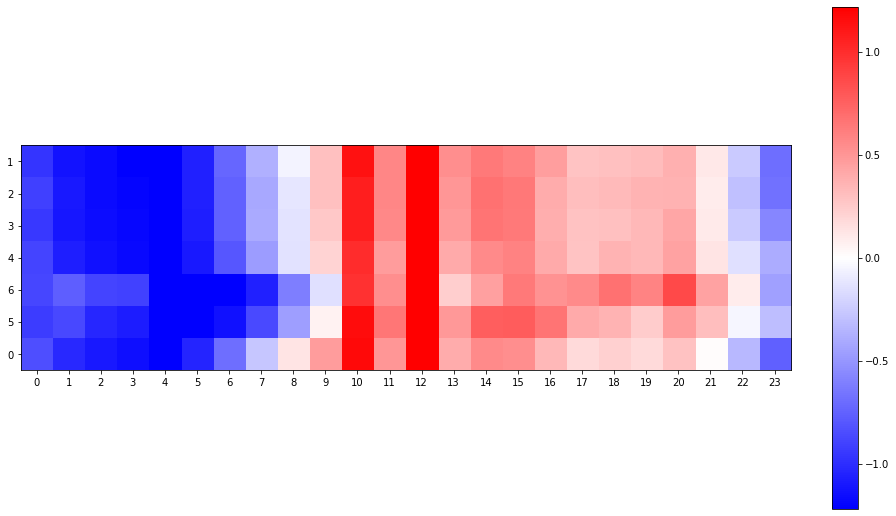

In [14]:
plt.figure(figsize=(15,12))
scale_and_plot(hora_x_dia, ix=np.arange(7))

Relación de tipo de delito por día.

C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


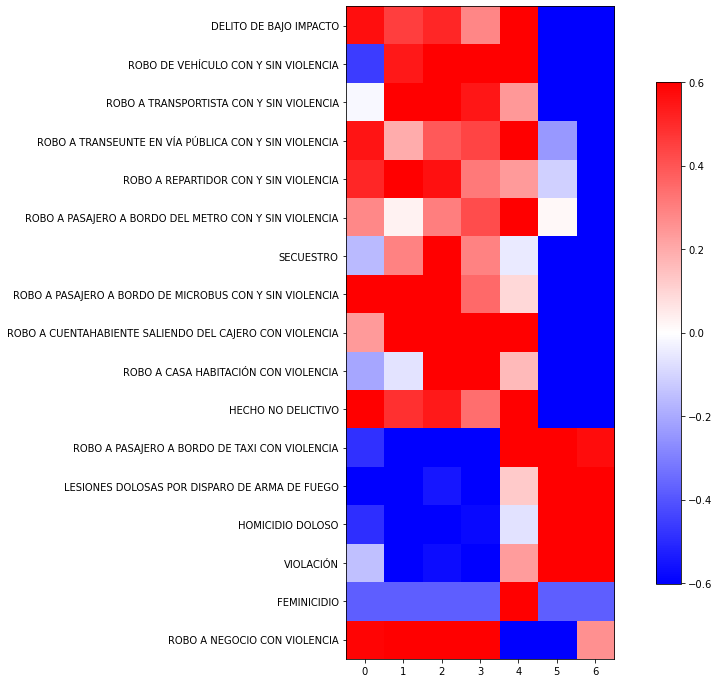

In [18]:
cat_x_dia = FGJ_carpetas.pivot_table(values="Unnamed: 0", index=FGJ_carpetas.index.weekday, 
                                      columns="categoria_delito", aggfunc=np.size).fillna(0)
cat_x_dia     = cat_x_dia.T
plt.figure(figsize=(15,12))
scale_and_plot(cat_x_dia)

Relacipon cantidad de delitos al día por delegación.

C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


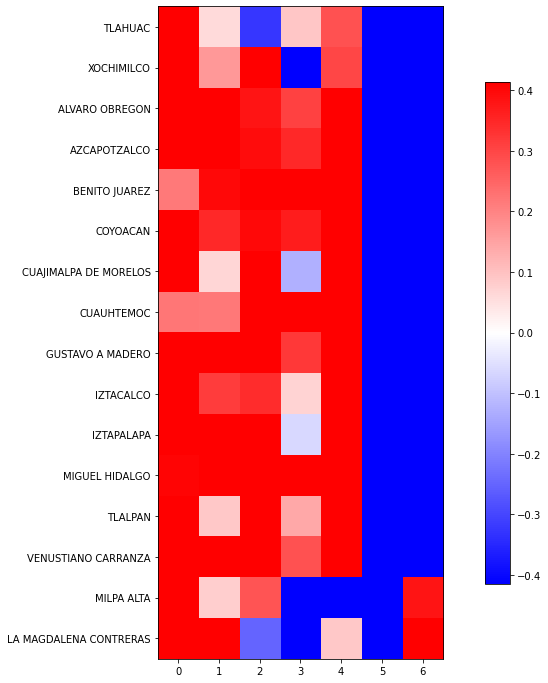

In [19]:
del_x_dia = FGJ_carpetas.pivot_table(values="Unnamed: 0", index=FGJ_carpetas.index.weekday, 
                                      columns="alcaldia_hechos", aggfunc=np.size).fillna(0)
del_x_dia     = del_x_dia.T
plt.figure(figsize=(15,12))
scale_and_plot(del_x_dia)

Relación de los delitos por tipo y delegación.

C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


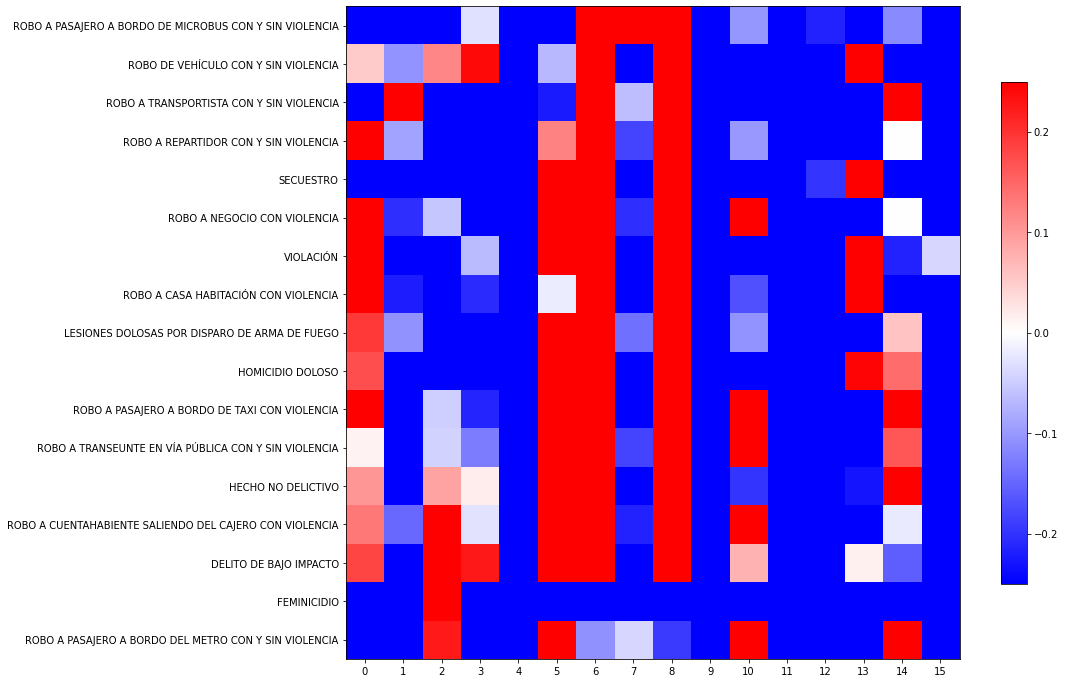

In [21]:
cat_x_del = FGJ_carpetas.pivot_table(values="Unnamed: 0", index="alcaldia_hechos", 
                                      columns="categoria_delito", aggfunc=np.size).fillna(0)
cat_x_del     = cat_x_del.T
plt.figure(figsize=(15,12))
scale_and_plot(cat_x_del)

In [5]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

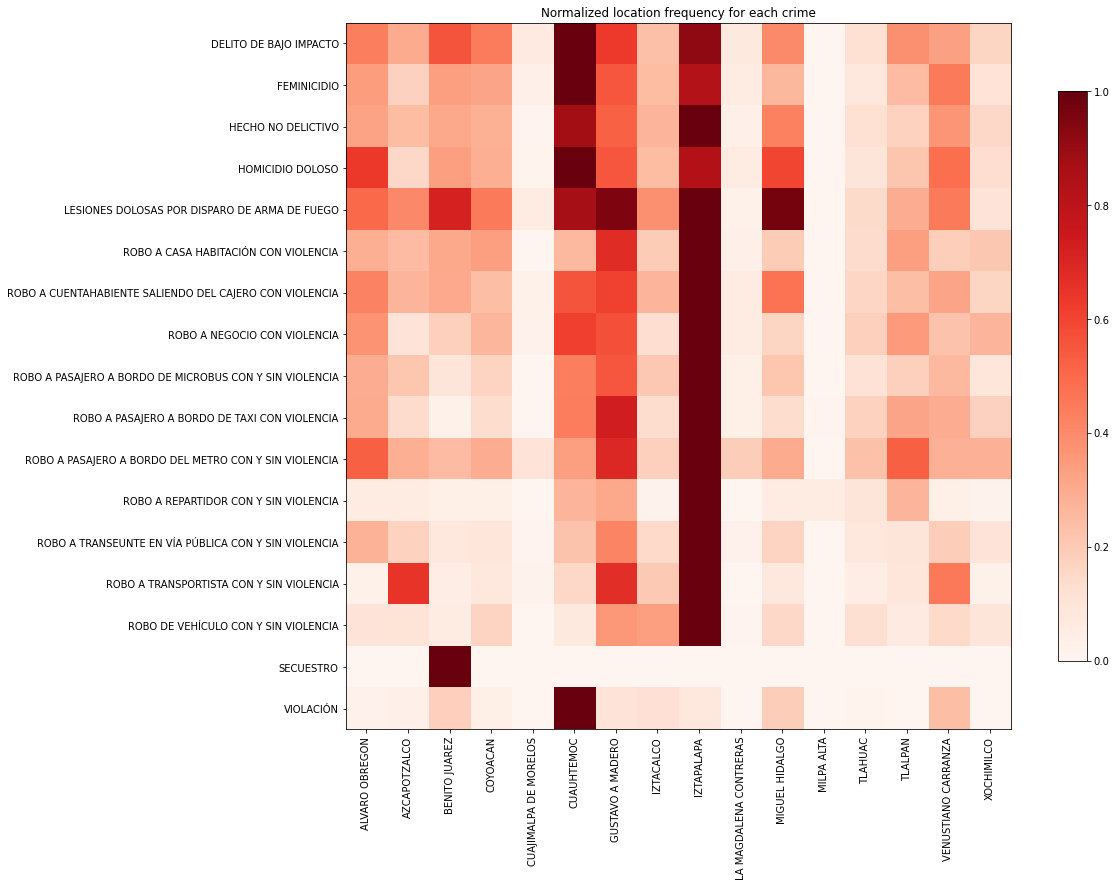

In [36]:
df = normalize(cat_x_del)
ix = AC(5).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

## Clustering a las Series por categoria: K-means

In [60]:
km_euc = TimeSeriesKMeans(n_clusters=4, 
                          verbose=2, 
                          n_init=10, 
                          metric="euclidean").fit(cat_x_semana.transpose())
labels_euc = km_euc.labels_
print(silhouette_score(cat_x_semana.transpose(), labels_euc, metric="euclidean"))
print(labels_euc)

Init 1
407448.647 --> 225554.955 --> 225554.955 --> 
Init 2
387845.647 --> 225554.955 --> 225554.955 --> 
Init 3
404092.176 --> 255402.690 --> 255402.690 --> 
Init 4
337240.000 --> 225554.955 --> 225554.955 --> 
Init 5
344396.706 --> 225554.955 --> 225554.955 --> 
Init 6
742849.353 --> 436359.631 --> 326357.920 --> 225554.955 --> 225554.955 --> 
Init 7
344396.706 --> 225554.955 --> 225554.955 --> 
Init 8
341813.588 --> 225554.955 --> 225554.955 --> 
Init 9
355574.588 --> 225554.955 --> 225554.955 --> 
Init 10
366222.588 --> 225554.955 --> 225554.955 --> 
0.6779753370146933
[1 0 3 0 0 0 0 0 0 0 0 0 2 0 2 0 0]


array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

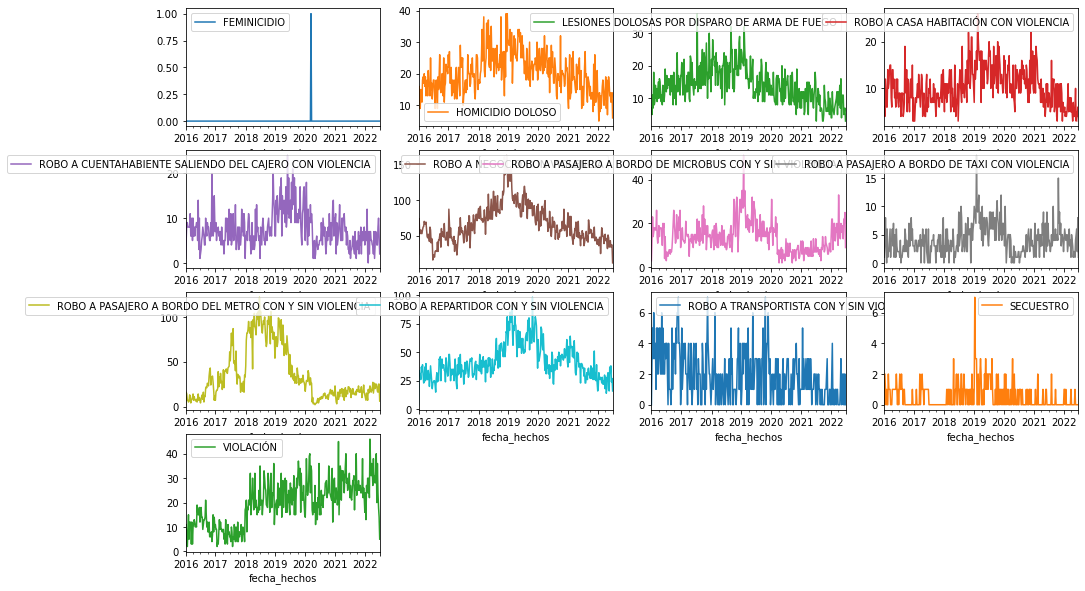

In [93]:
cat_x_semana.iloc[:,labels_euc==0].plot(figsize=(16, 10), subplots=True, layout=(-1, 4), sharex=False, sharey=False)

## Baseline: Modelo SARIMA

Para el total de delitos cometidos por semana, es decir un modelo agregadao. Se utilizará como conjunto de etrenamiento los datos de la semanas hasta antes del año 2022 y como conjunto de prueba/validación los registros a partir del año 2022.

In [60]:
del_x_sem = FGJ_carpetas.resample("W", on = "fecha_hechos").size()
ts_train=del_x_sem[del_x_sem.index<'2022']
ts_test=del_x_sem[del_x_sem.index>='2022']

## Descomposición

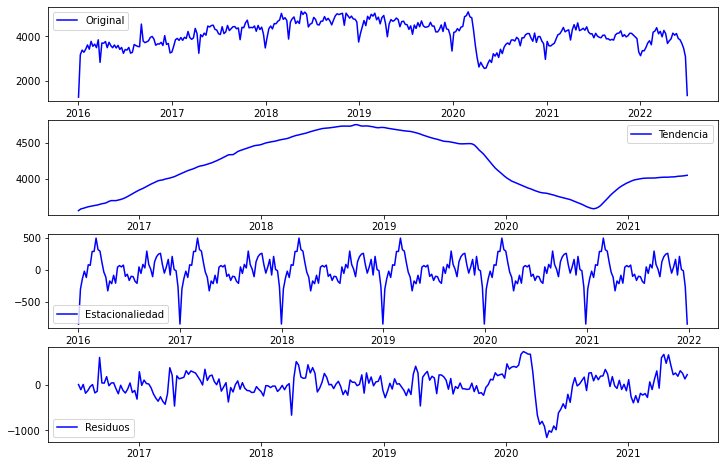

In [63]:
decomposition = seasonal_decompose(ts_train, model="additive",  period=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(del_x_sem, label = "Original", color = "blue")
plt.legend(loc = "best")
plt.subplot(412)
plt.plot(trend, label = "Tendencia", color = "blue")
plt. legend(loc = "best")
plt.subplot(413)
plt.plot(seasonal, label = "Estacionaliedad", color = "blue")
plt. legend(loc = "best")
plt.subplot(414)
plt.plot(residual, label = "Residuos", color = "blue")
plt. legend(loc = "best")

Modelo usando `auto_arima()`

*Correr en Colab*

In [ ]:
model = pm.auto_arima(ts_train, 
                      test='adf',
                      seasonal=True,
                      m=52,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

El mejor modelo resulta ser un SARIMA(3,1,0)(1,0,0)[52]

In [105]:
model=SARIMAX(ts_train, order=(3,1,0), seasonal_order=(1, 0, 0, 52))
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  313
Model:             SARIMAX(3, 1, 0)x(1, 0, 0, 52)   Log Likelihood               -2194.875
Date:                            Thu, 22 Sep 2022   AIC                           4399.750
Time:                                    12:43:05   BIC                           4418.465
Sample:                                01-03-2016   HQIC                          4407.230
                                     - 12-26-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3503      0.034    -10.361      0.000      -0.417      -0.284
ar.L2         -0.1229      0.057     -2.140      0.032      -0.235      -0.010
ar.L3         -0.0885      0.062     -1.426      0.154      -0.210       0.033
ar.S.L52       0.3069      0.042      7.337      0.000       0.225       0.389
sigma2      7.381e+04   3095.659     23.844      0.000    6.77e+04    7.99e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):               603.23
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

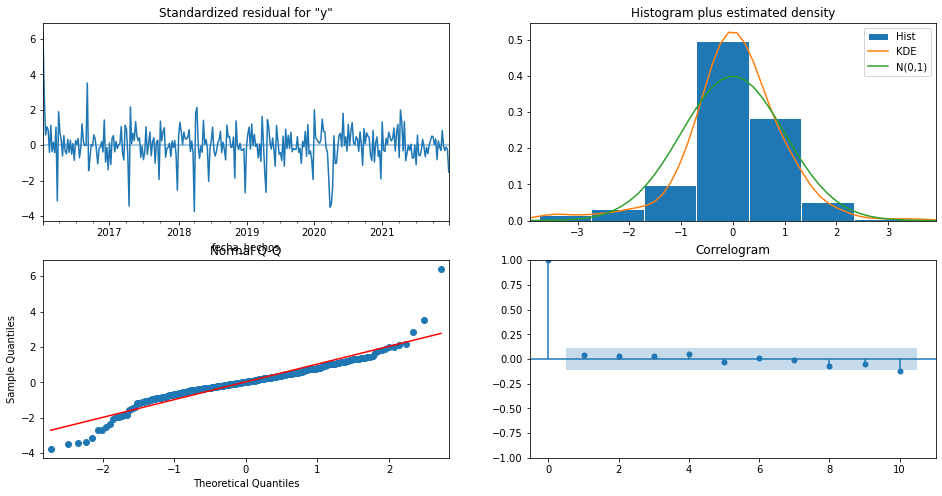

In [106]:
result.plot_diagnostics(figsize=(16,8))
plt.show()

## Predicción

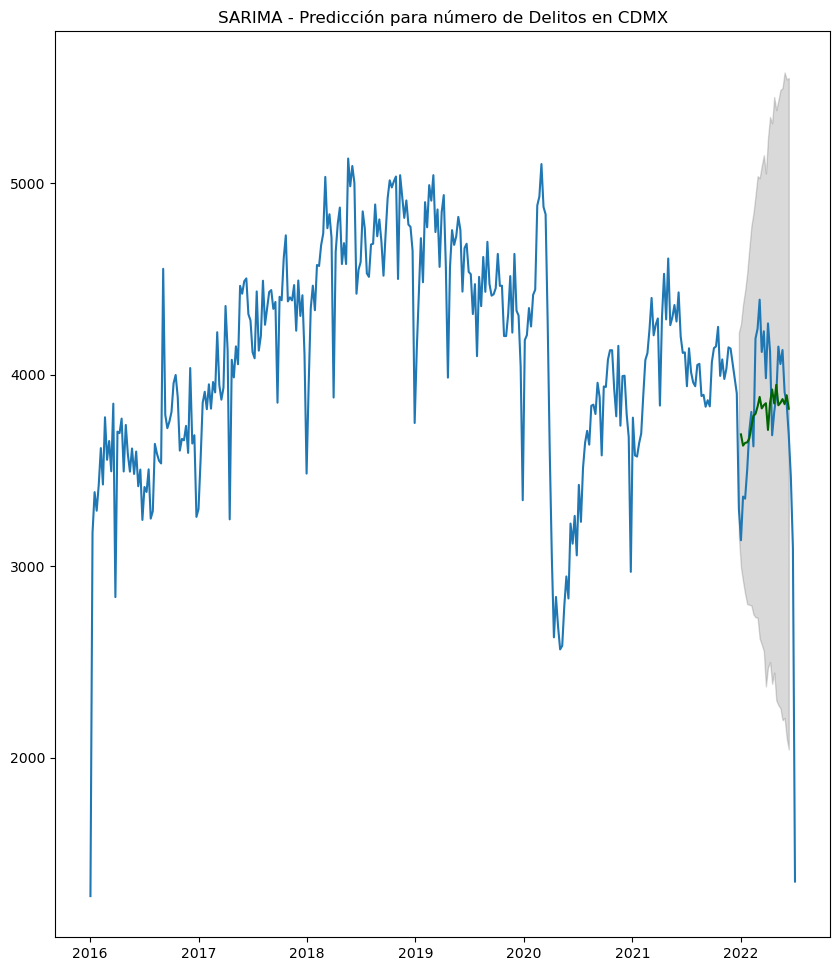

In [138]:
# Forecast
n_periods = 25
fitted = result.get_forecast(n_periods).predicted_mean
index_of_fc = pd.date_range(ts_train.index[-1], periods = n_periods, freq='W-SUN')
confint = result.get_forecast(25).conf_int()
#lower_series = pd.Series(confit["lower y"], index=index_of_fc)
#upper_series = pd.Series(confint["upper y"], index=index_of_fc)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
# Plot
plt.figure(figsize=(10,12), dpi=100)
plt.plot(del_x_sem)
plt.plot(fitted_series, color='darkgreen')
#plt.plot(lower_series, color='k')
#plt.plot(upper_series, color='k')
plt.fill_between(index_of_fc, confint["upper y"].values, confint["lower y"].values, color='k', 
                    alpha=.15)

plt.title("SARIMA - Predicción para número de Delitos en CDMX")
plt.show()